In [1]:
# check if we are connected to the GPU
!nvidia-smi

Sun Feb  1 02:36:09 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# preprocess the image.
# Just put the image here.

from PIL import Image
img = Image.open("image.jpg").convert("L").resize((1024, 1024))
img.save("input.pgm")


**3 filters we have:**
- edge detection
- Sharpen
- Gaussian Blur

Different M means the image size MxM.

Different N means different filter size NxN.

----

<br>

---


<br>

---

## **CPU: All N's together with performance**

In [3]:
%%writefile convo.c
#include <stdio.h>
#include <stdlib.h>
#include <stdint.h>
#include <ctype.h>
#include <string.h>
#include <time.h>

#define DEFAULT_M 512

static inline uint8_t clamp_to_u8(int32_t v) {
    if (v < 0) return 0;
    if (v > 255) return 255;
    return (uint8_t)v;
}

static void skip_ws_and_comments(FILE *f) {
    int c;
    while ((c = fgetc(f)) != EOF) {
        if (isspace(c)) continue;
        if (c == '#') { while ((c = fgetc(f)) != EOF && c != '\n') {} continue; }
        ungetc(c, f);
        return;
    }
}

// Zero-padding pixel read for boundary
static uint8_t get_pixel_zero_pad(const uint8_t *img, int W, int H, int x, int y) {
    if (x < 0 || x >= W || y < 0 || y >= H) return 0;
    return img[y * W + x];
}

// Readindg the binary, maxval=255
static uint8_t* read_pgm_p5(const char *path, int *W, int *H) {
    FILE *f = fopen(path, "rb");
    if (!f) { perror("fopen"); return NULL; }

    char magic[3] = {0};
    if (fread(magic, 1, 2, f) != 2 || magic[0] != 'P' || magic[1] != '5') {
        fprintf(stderr, "Not a binary PGM (P5): %s\n", path);
        fclose(f);
        return NULL;
    }

    skip_ws_and_comments(f);
    if (fscanf(f, "%d", W) != 1) { fclose(f); return NULL; }

    skip_ws_and_comments(f);
    if (fscanf(f, "%d", H) != 1) { fclose(f); return NULL; }

    skip_ws_and_comments(f);
    int maxval = 0;
    if (fscanf(f, "%d", &maxval) != 1 || maxval != 255) {
        fprintf(stderr, "PGM maxval must be 255 (got %d)\n", maxval);
        fclose(f);
        return NULL;
    }

    fgetc(f);

    size_t n = (size_t)(*W) * (size_t)(*H);
    uint8_t *img = (uint8_t*)malloc(n);
    if (!img) { perror("malloc"); fclose(f); return NULL; }

    if (fread(img, 1, n, f) != n) {
        fprintf(stderr, "Failed reading pixel data\n");
        free(img);
        fclose(f);
        return NULL;
    }

    fclose(f);
    return img;
}

// Writing the binary
static int write_pgm_p5(const char *path, const uint8_t *img, int W, int H) {
    FILE *f = fopen(path, "wb");
    if (!f) { perror("fopen"); return 0; }

    fprintf(f, "P5\n%d %d\n255\n", W, H);

    size_t n = (size_t)W * (size_t)H;
    if (fwrite(img, 1, n, f) != n) { fclose(f); return 0; }

    fclose(f);
    return 1;
}

// ============================================================
// edge kernels
// ============================================================

// EDGE N=3:
static void edge_n3(const uint8_t *image, uint8_t *out, int W, int H) {
    const int32_t K[9] = {
         0, -1,  0,
        -1,  4, -1,
         0, -1,  0
    };
    int r = 1;

    for (int y = 0; y < H; y++) {
        for (int x = 0; x < W; x++) {
            int32_t sum = 0;

            for (int ky = 0; ky < 3; ky++) {
                for (int kx = 0; kx < 3; kx++) {
                    int ix = x + (kx - r);
                    int iy = y + (ky - r);
                    uint8_t p = get_pixel_zero_pad(image, W, H, ix, iy);
                    sum += (int32_t)p * K[ky * 3 + kx];
                }
            }

            if (sum < 0) sum = -sum;
            out[y * W + x] = clamp_to_u8(sum);
        }
    }
}

// EDGE N=5: (similar logic with N=3, high center and negative corners)
static void edge_n5(const uint8_t *image, uint8_t *out, int W, int H) {
    const int32_t K[25] = {
        -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1,
        -1, -1, 24, -1, -1,
        -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1
    };
    int r = 2;

    for (int y = 0; y < H; y++) {
        for (int x = 0; x < W; x++) {
            int32_t sum = 0;

            for (int ky = 0; ky < 5; ky++) {
                for (int kx = 0; kx < 5; kx++) {
                    int ix = x + (kx - r);
                    int iy = y + (ky - r);
                    uint8_t p = get_pixel_zero_pad(image, W, H, ix, iy);
                    sum += (int32_t)p * K[ky * 5 + kx];
                }
            }

            if (sum < 0) sum = -sum;
            out[y * W + x] = clamp_to_u8(sum);
        }
    }
}

// EDGE N=7: (same thing as other edge detections, big center and -1 edges/corners)
static void edge_n7(const uint8_t *image, uint8_t *out, int W, int H) {
    const int32_t K[49] = {
        -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, 48, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1
    };
    int r = 3;

    for (int y = 0; y < H; y++) {
        for (int x = 0; x < W; x++) {
            int32_t sum = 0;

            for (int ky = 0; ky < 7; ky++) {
                for (int kx = 0; kx < 7; kx++) {
                    int ix = x + (kx - r);
                    int iy = y + (ky - r);
                    uint8_t p = get_pixel_zero_pad(image, W, H, ix, iy);
                    sum += (int32_t)p * K[ky * 7 + kx];
                }
            }

            if (sum < 0) sum = -sum;
            out[y * W + x] = clamp_to_u8(sum);
        }
    }
}

// ============================================================
// Sharpen kernels
// ============================================================

static void sharpen_n3(const uint8_t *image, uint8_t *out, int W, int H) {
    const int32_t K[9] = {
        -1, -1, -1,
        -1,  9, -1,
        -1, -1, -1
    };
    int r = 1;

    for (int y = 0; y < H; y++) {
        for (int x = 0; x < W; x++) {
            int32_t sum = 0;

            for (int ky = 0; ky < 3; ky++) {
                for (int kx = 0; kx < 3; kx++) {
                    int ix = x + (kx - r);
                    int iy = y + (ky - r);
                    uint8_t p = get_pixel_zero_pad(image, W, H, ix, iy);
                    sum += (int32_t)p * K[ky * 3 + kx];
                }
            }

            out[y * W + x] = clamp_to_u8(sum);
        }
    }
}

static void sharpen_n5(const uint8_t *image, uint8_t *out, int W, int H) {
    const int32_t K[25] = {
        -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1,
        -1, -1, 25, -1, -1,
        -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1
    };
    int r = 2;

    for (int y = 0; y < H; y++) {
        for (int x = 0; x < W; x++) {
            int32_t sum = 0;

            for (int ky = 0; ky < 5; ky++) {
                for (int kx = 0; kx < 5; kx++) {
                    int ix = x + (kx - r);
                    int iy = y + (ky - r);
                    uint8_t p = get_pixel_zero_pad(image, W, H, ix, iy);
                    sum += (int32_t)p * K[ky * 5 + kx];
                }
            }

            out[y * W + x] = clamp_to_u8(sum);
        }
    }
}

static void sharpen_n7(const uint8_t *image, uint8_t *out, int W, int H) {
    const int32_t K[49] = {
        -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, 49, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1
    };
    int r = 3;

    for (int y = 0; y < H; y++) {
        for (int x = 0; x < W; x++) {
            int32_t sum = 0;

            for (int ky = 0; ky < 7; ky++) {
                for (int kx = 0; kx < 7; kx++) {
                    int ix = x + (kx - r);
                    int iy = y + (ky - r);
                    uint8_t p = get_pixel_zero_pad(image, W, H, ix, iy);
                    sum += (int32_t)p * K[ky * 7 + kx];
                }
            }

            out[y * W + x] = clamp_to_u8(sum);
        }
    }
}

// ============================================================
// Gaussian blur kernelss
// ============================================================

static void blur_n3(const uint8_t *image, uint8_t *out, int W, int H) {
    const int32_t K[9] = {
        1, 2, 1,
        2, 4, 2,
        1, 2, 1
    };
    int r = 1;

    for (int y = 0; y < H; y++) {
        for (int x = 0; x < W; x++) {
            int32_t sum = 0;

            for (int ky = 0; ky < 3; ky++) {
                for (int kx = 0; kx < 3; kx++) {
                    int ix = x + (kx - r);
                    int iy = y + (ky - r);
                    uint8_t p = get_pixel_zero_pad(image, W, H, ix, iy);
                    sum += (int32_t)p * K[ky * 3 + kx];
                }
            }

            sum /= 16; // normalization with dividing by 16 (from wikipedia page)
            out[y * W + x] = clamp_to_u8(sum);
        }
    }
}

static void blur_n5(const uint8_t *image, uint8_t *out, int W, int H) {
    const int32_t K[25] = {
         1,  4,  6,  4,  1,
         4, 16, 24, 16,  4,
         6, 24, 36, 24,  6,
         4, 16, 24, 16,  4,
         1,  4,  6,  4,  1
    };
    int r = 2;

    for (int y = 0; y < H; y++) {
        for (int x = 0; x < W; x++) {
            int32_t sum = 0;

            for (int ky = 0; ky < 5; ky++) {
                for (int kx = 0; kx < 5; kx++) {
                    int ix = x + (kx - r);
                    int iy = y + (ky - r);
                    uint8_t p = get_pixel_zero_pad(image, W, H, ix, iy);
                    sum += (int32_t)p * K[ky * 5 + kx];
                }
            }

            sum /= 256; // normalization
            out[y * W + x] = clamp_to_u8(sum);
        }
    }
}

static void blur_n7(const uint8_t *image, uint8_t *out, int W, int H) {
    // Got the values from internet. Sum is equal to 4096.
    const int32_t K[49] = {
          1,   6,  15,  20,  15,   6,   1,
          6,  36,  90, 120,  90,  36,   6,
         15,  90, 225, 300, 225,  90,  15,
         20, 120, 300, 400, 300, 120,  20,
         15,  90, 225, 300, 225,  90,  15,
          6,  36,  90, 120,  90,  36,   6,
          1,   6,  15,  20,  15,   6,   1
    };
    int r = 3;

    for (int y = 0; y < H; y++) {
        for (int x = 0; x < W; x++) {
            int32_t sum = 0;

            for (int ky = 0; ky < 7; ky++) {
                for (int kx = 0; kx < 7; kx++) {
                    int ix = x + (kx - r);
                    int iy = y + (ky - r);
                    uint8_t p = get_pixel_zero_pad(image, W, H, ix, iy);
                    sum += (int32_t)p * K[ky * 7 + kx];
                }
            }

            sum /= 4096; // normalization
            out[y * W + x] = clamp_to_u8(sum);
        }
    }
}

// ============================================================
// main
// ============================================================

int main(int argc, char **argv) {

    const char *mode = argv[3];

    int M = DEFAULT_M;
    if (argc == 5) {
        M = atoi(argv[4]);
    }

    int W0 = 0, H0 = 0;
    uint8_t *img0 = read_pgm_p5(argv[1], &W0, &H0);
    if (!img0) return 1;

    int max_square = (W0 < H0) ? W0 : H0;
    if (M > max_square) {
        fprintf(stderr, "Warning: requested M=%d but input is %dx%d; using M=%d\n",
                M, W0, H0, max_square);
        M = max_square;
    }

    size_t n = (size_t)M * (size_t)M;

    // Copying the top-left MxM into the buffer
    uint8_t *img = (uint8_t*)malloc(n);
    if (!img) { perror("malloc"); free(img0); return 1; }

    uint8_t *out = (uint8_t*)malloc(n);
    if (!out) { perror("malloc"); free(img0); free(img); return 1; }

    for (int y = 0; y < M; y++) {
        memcpy(&img[y * M], &img0[y * W0], (size_t)M);
    }

    clock_t start = clock();

    if (strcmp(mode, "edge_n3") == 0) edge_n3(img, out, M, M);
    else if (strcmp(mode, "edge_n5") == 0) edge_n5(img, out, M, M);
    else if (strcmp(mode, "edge_n7") == 0) edge_n7(img, out, M, M);

    else if (strcmp(mode, "sharpen_n3") == 0) sharpen_n3(img, out, M, M);
    else if (strcmp(mode, "sharpen_n5") == 0) sharpen_n5(img, out, M, M);
    else if (strcmp(mode, "sharpen_n7") == 0) sharpen_n7(img, out, M, M);

    else if (strcmp(mode, "blur_n3") == 0) blur_n3(img, out, M, M);
    else if (strcmp(mode, "blur_n5") == 0) blur_n5(img, out, M, M);
    else if (strcmp(mode, "blur_n7") == 0) blur_n7(img, out, M, M);

    else {
        fprintf(stderr, "Unknown mode '%s'\n", mode);
        free(img0); free(img); free(out);
        return 1;
    }

    clock_t end = clock();
    double ms = 1000.0 * (double)(end - start) / (double)CLOCKS_PER_SEC;

    int N = (strstr(mode, "_n3") ? 3 : (strstr(mode, "_n5") ? 5 : 7));
    printf("Compute time (convolution only): mode=%s, N=%d, M=%d -> %.3f ms\n", mode, N, M, ms);

    if (!write_pgm_p5(argv[2], out, M, M)) {
        fprintf(stderr, "Failed writing output\n");
        free(img0); free(img); free(out);
        return 1;
    }

    free(img0);
    free(img);
    free(out);
    return 0;
}


Writing convo.c


In [4]:
! gcc -O2 convo.c -o convo

# ---------------- M = 256 ----------------
! ./convo input.pgm out_edge_n3_256.pgm    edge_n3    256
! ./convo input.pgm out_edge_n5_256.pgm    edge_n5    256
! ./convo input.pgm out_edge_n7_256.pgm    edge_n7    256

! ./convo input.pgm out_sharp_n3_256.pgm   sharpen_n3 256
! ./convo input.pgm out_sharp_n5_256.pgm   sharpen_n5 256
! ./convo input.pgm out_sharp_n7_256.pgm   sharpen_n7 256

! ./convo input.pgm out_blur_n7_256.pgm    blur_n7    256
! ./convo input.pgm out_blur_n3_256.pgm    blur_n3    256
! ./convo input.pgm out_blur_n5_256.pgm    blur_n5    256

# ---------------- M = 512 ----------------
! ./convo input.pgm out_edge_n3_512.pgm    edge_n3    512
! ./convo input.pgm out_edge_n5_512.pgm    edge_n5    512
! ./convo input.pgm out_edge_n7_512.pgm    edge_n7    512

! ./convo input.pgm out_sharp_n3_512.pgm   sharpen_n3 512
! ./convo input.pgm out_sharp_n5_512.pgm   sharpen_n5 512
! ./convo input.pgm out_sharp_n7_512.pgm   sharpen_n7 512

! ./convo input.pgm out_blur_n3_512.pgm    blur_n3    512
! ./convo input.pgm out_blur_n5_512.pgm    blur_n5    512
! ./convo input.pgm out_blur_n7_512.pgm    blur_n7    512

# ---------------- M = 1024 ----------------
! ./convo input.pgm out_edge_n3_1024.pgm   edge_n3    1024
! ./convo input.pgm out_edge_n5_1024.pgm   edge_n5    1024
! ./convo input.pgm out_edge_n7_1024.pgm   edge_n7    1024

! ./convo input.pgm out_sharp_n3_1024.pgm  sharpen_n3 1024
! ./convo input.pgm out_sharp_n5_1024.pgm  sharpen_n5 1024
! ./convo input.pgm out_sharp_n7_1024.pgm  sharpen_n7 1024

! ./convo input.pgm out_blur_n3_1024.pgm   blur_n3    1024
! ./convo input.pgm out_blur_n5_1024.pgm   blur_n5    1024
! ./convo input.pgm out_blur_n7_1024.pgm   blur_n7    1024


Compute time (convolution only): mode=edge_n3, N=3, M=256 -> 2.624 ms
Compute time (convolution only): mode=edge_n5, N=5, M=256 -> 4.163 ms
Compute time (convolution only): mode=edge_n7, N=7, M=256 -> 11.966 ms
Compute time (convolution only): mode=sharpen_n3, N=3, M=256 -> 1.976 ms
Compute time (convolution only): mode=sharpen_n5, N=5, M=256 -> 4.577 ms
Compute time (convolution only): mode=sharpen_n7, N=7, M=256 -> 8.601 ms
Compute time (convolution only): mode=blur_n7, N=7, M=256 -> 12.332 ms
Compute time (convolution only): mode=blur_n3, N=3, M=256 -> 2.498 ms
Compute time (convolution only): mode=blur_n5, N=5, M=256 -> 4.775 ms
Compute time (convolution only): mode=edge_n3, N=3, M=512 -> 9.711 ms
Compute time (convolution only): mode=edge_n5, N=5, M=512 -> 18.433 ms
Compute time (convolution only): mode=edge_n7, N=7, M=512 -> 43.063 ms
Compute time (convolution only): mode=sharpen_n3, N=3, M=512 -> 7.289 ms
Compute time (convolution only): mode=sharpen_n5, N=5, M=512 -> 17.728 ms


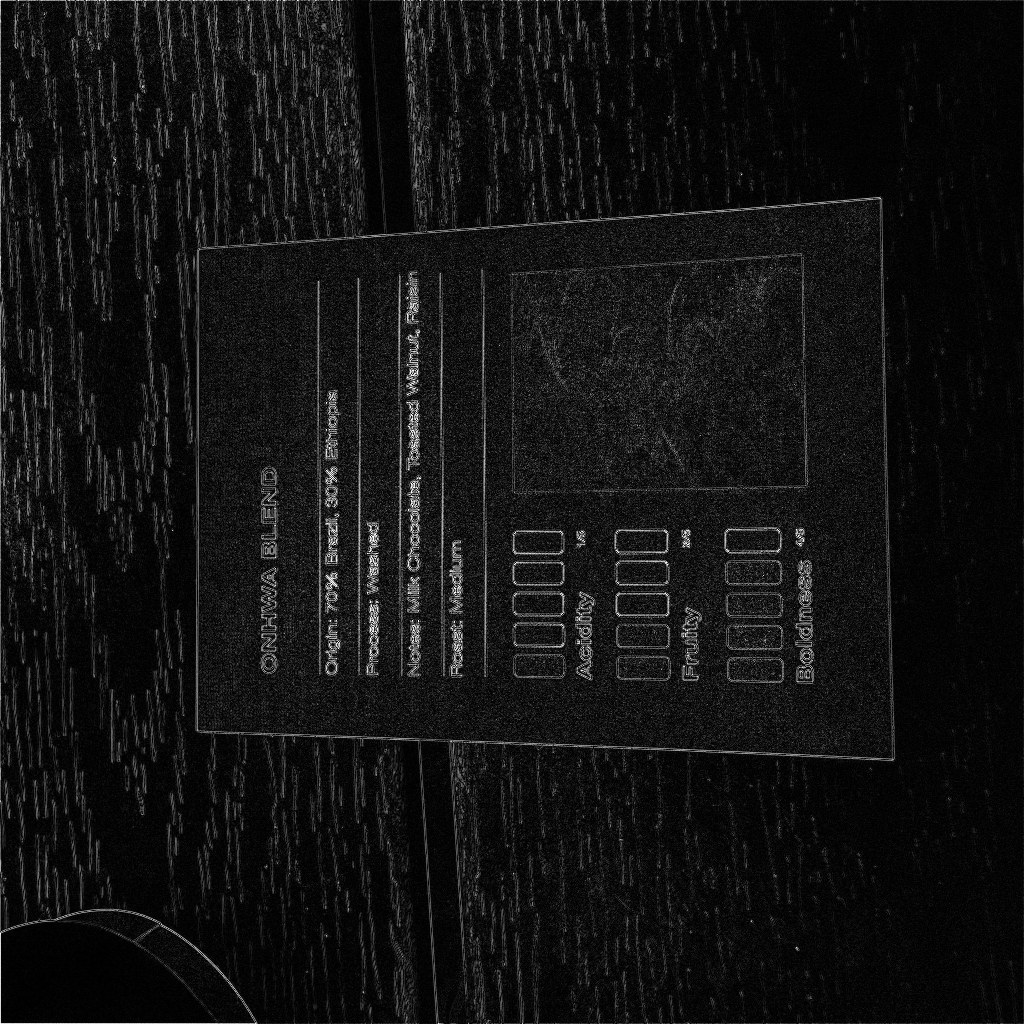

In [5]:
# display some images
from PIL import Image
Image.open("out_edge_n3_1024.pgm")

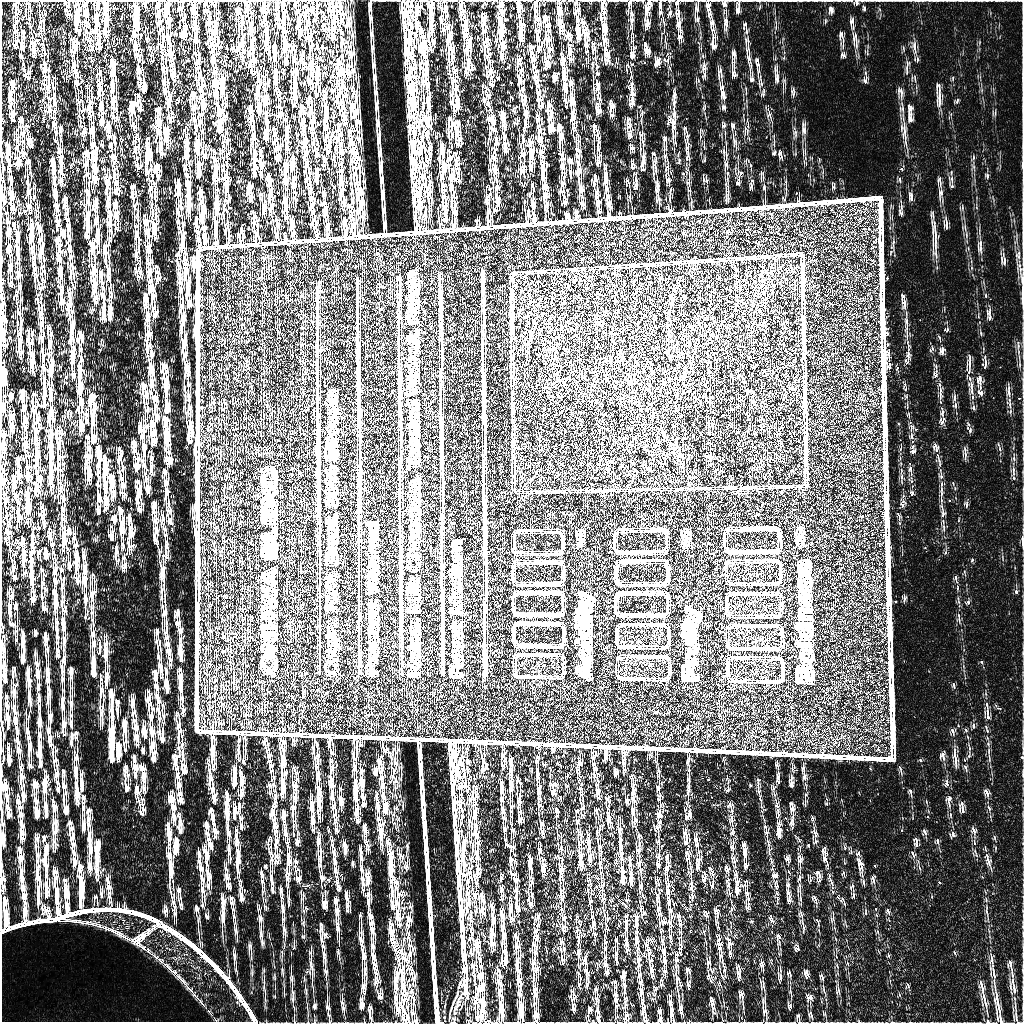

In [6]:
Image.open("out_edge_n5_1024.pgm")

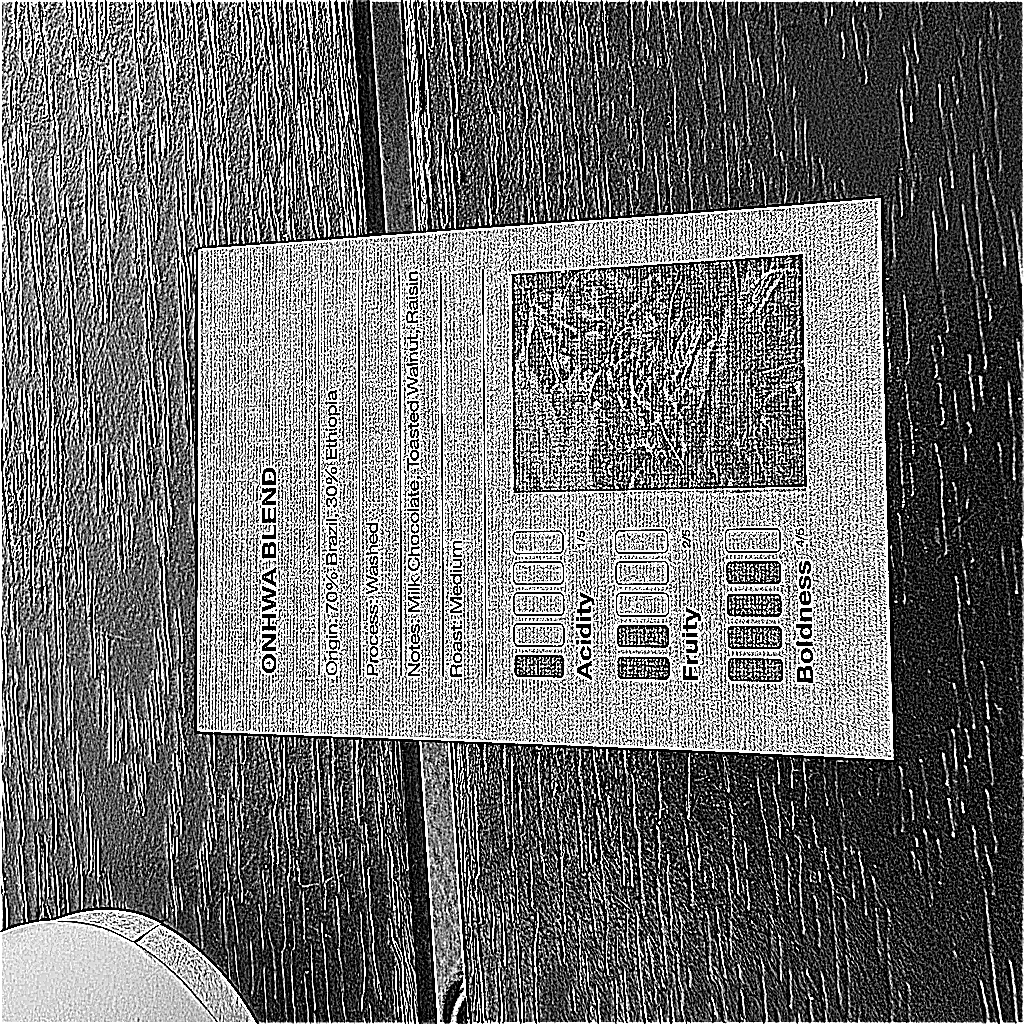

In [7]:
Image.open("out_sharp_n5_1024.pgm")

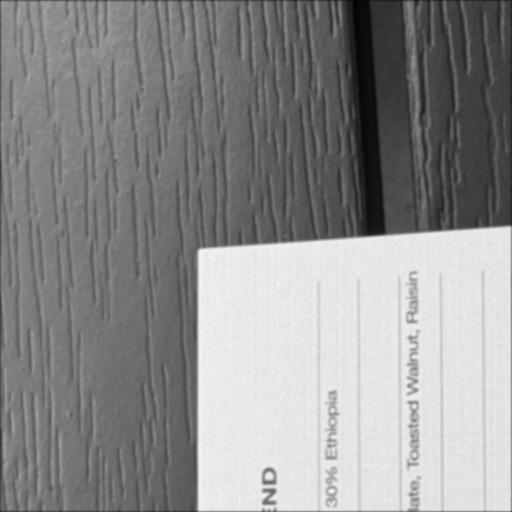

In [8]:
Image.open("out_blur_n7_512.pgm")

## **Step 2: Porting the Convolution Function to CUDA**

In [9]:
%%writefile convo_cuda.cu
#include <stdio.h>
#include <stdlib.h>
#include <stdint.h>
#include <ctype.h>
#include <string.h>

#include <cuda_runtime.h>

#define DEFAULT_M 512
static void skip_ws_and_comments(FILE *f) {
    int c;
    while ((c = fgetc(f)) != EOF) {
        if (isspace(c)) continue;
        if (c == '#') { while ((c = fgetc(f)) != EOF && c != '\n') {} continue; }
        ungetc(c, f);
        return;
    }
}

// Read binary, maxval=255.
static uint8_t* read_pgm_p5(const char *path, int *W, int *H) {
    FILE *f = fopen(path, "rb");
    if (!f) { perror("fopen"); return NULL; }

    char magic[3] = {0};
    if (fread(magic, 1, 2, f) != 2 || magic[0] != 'P' || magic[1] != '5') {
        fprintf(stderr, "Not a binary PGM (P5): %s\n", path);
        fclose(f);
        return NULL;
    }

    skip_ws_and_comments(f);
    if (fscanf(f, "%d", W) != 1) { fclose(f); return NULL; }

    skip_ws_and_comments(f);
    if (fscanf(f, "%d", H) != 1) { fclose(f); return NULL; }

    skip_ws_and_comments(f);
    int maxval = 0;
    if (fscanf(f, "%d", &maxval) != 1 || maxval != 255) {
        fprintf(stderr, "PGM maxval must be 255 (got %d)\n", maxval);
        fclose(f);
        return NULL;
    }
    fgetc(f);
    size_t n = (size_t)(*W) * (size_t)(*H);
    uint8_t *img = (uint8_t*)malloc(n);
    if (!img) { perror("malloc"); fclose(f); return NULL; }

    if (fread(img, 1, n, f) != n) {
        fprintf(stderr, "Failed reading pixel data\n");
        free(img);
        fclose(f);
        return NULL;
    }

    fclose(f);
    return img;
}

// Writing the binary
static int write_pgm_p5(const char *path, const uint8_t *img, int W, int H) {
    FILE *f = fopen(path, "wb");
    if (!f) { perror("fopen"); return 0; }

    fprintf(f, "P5\n%d %d\n255\n", W, H);

    size_t n = (size_t)W * (size_t)H;
    if (fwrite(img, 1, n, f) != n) { fclose(f); return 0; }

    fclose(f);
    return 1;
}

// ============================================================
// edge kernels (Same code as the previous code block)
// ============================================================

__global__ void k_edge_n3(const uint8_t *image, uint8_t *out, int W, int H) {
    const int32_t K[9] = {
         0, -1,  0,
        -1,  4, -1,
         0, -1,  0
    };
    int r = 1;

    int x = (int)(blockIdx.x * blockDim.x + threadIdx.x);
    int y = (int)(blockIdx.y * blockDim.y + threadIdx.y);
    if (x >= W || y >= H) return;

    int32_t sum = 0;

    for (int ky = 0; ky < 3; ky++) {
        for (int kx = 0; kx < 3; kx++) {
            int ix = x + (kx - r);
            int iy = y + (ky - r);

            uint8_t p = 0;
            if (ix >= 0 && ix < W && iy >= 0 && iy < H) {
                p = image[iy * W + ix];
            }

            sum += (int32_t)p * K[ky * 3 + kx];
        }
    }

    if (sum < 0) sum = -sum;
    if (sum < 0) sum = 0;
    if (sum > 255) sum = 255;
    out[y * W + x] = (uint8_t)sum;
}

__global__ void k_edge_n5(const uint8_t *image, uint8_t *out, int W, int H) {
    const int32_t K[25] = {
        -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1,
        -1, -1, 24, -1, -1,
        -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1
    };
    int r = 2;

    int x = (int)(blockIdx.x * blockDim.x + threadIdx.x);
    int y = (int)(blockIdx.y * blockDim.y + threadIdx.y);
    if (x >= W || y >= H) return;

    int32_t sum = 0;

    for (int ky = 0; ky < 5; ky++) {
        for (int kx = 0; kx < 5; kx++) {
            int ix = x + (kx - r);
            int iy = y + (ky - r);

            uint8_t p = 0;
            if (ix >= 0 && ix < W && iy >= 0 && iy < H) {
                p = image[iy * W + ix];
            }

            sum += (int32_t)p * K[ky * 5 + kx];
        }
    }

    if (sum < 0) sum = -sum;
    if (sum < 0) sum = 0;
    if (sum > 255) sum = 255;
    out[y * W + x] = (uint8_t)sum;
}

__global__ void k_edge_n7(const uint8_t *image, uint8_t *out, int W, int H) {
    const int32_t K[49] = {
        -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, 48, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1
    };
    int r = 3;

    int x = (int)(blockIdx.x * blockDim.x + threadIdx.x);
    int y = (int)(blockIdx.y * blockDim.y + threadIdx.y);
    if (x >= W || y >= H) return;

    int32_t sum = 0;

    for (int ky = 0; ky < 7; ky++) {
        for (int kx = 0; kx < 7; kx++) {
            int ix = x + (kx - r);
            int iy = y + (ky - r);

            uint8_t p = 0;
            if (ix >= 0 && ix < W && iy >= 0 && iy < H) {
                p = image[iy * W + ix];
            }

            sum += (int32_t)p * K[ky * 7 + kx];
        }
    }

    if (sum < 0) sum = -sum;
    if (sum < 0) sum = 0;
    if (sum > 255) sum = 255;
    out[y * W + x] = (uint8_t)sum;
}

__global__ void k_sharpen_n3(const uint8_t *image, uint8_t *out, int W, int H) {
    const int32_t K[9] = {
        -1, -1, -1,
        -1,  9, -1,
        -1, -1, -1
    };
    int r = 1;

    int x = (int)(blockIdx.x * blockDim.x + threadIdx.x);
    int y = (int)(blockIdx.y * blockDim.y + threadIdx.y);
    if (x >= W || y >= H) return;

    int32_t sum = 0;

    for (int ky = 0; ky < 3; ky++) {
        for (int kx = 0; kx < 3; kx++) {
            int ix = x + (kx - r);
            int iy = y + (ky - r);

            uint8_t p = 0;
            if (ix >= 0 && ix < W && iy >= 0 && iy < H) {
                p = image[iy * W + ix];
            }

            sum += (int32_t)p * K[ky * 3 + kx];
        }
    }

    if (sum < 0) sum = 0;
    if (sum > 255) sum = 255;
    out[y * W + x] = (uint8_t)sum;
}

__global__ void k_sharpen_n5(const uint8_t *image, uint8_t *out, int W, int H) {
    const int32_t K[25] = {
        -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1,
        -1, -1, 25, -1, -1,
        -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1
    };
    int r = 2;

    int x = (int)(blockIdx.x * blockDim.x + threadIdx.x);
    int y = (int)(blockIdx.y * blockDim.y + threadIdx.y);
    if (x >= W || y >= H) return;

    int32_t sum = 0;

    for (int ky = 0; ky < 5; ky++) {
        for (int kx = 0; kx < 5; kx++) {
            int ix = x + (kx - r);
            int iy = y + (ky - r);

            uint8_t p = 0;
            if (ix >= 0 && ix < W && iy >= 0 && iy < H) {
                p = image[iy * W + ix];
            }

            sum += (int32_t)p * K[ky * 5 + kx];
        }
    }

    if (sum < 0) sum = 0;
    if (sum > 255) sum = 255;
    out[y * W + x] = (uint8_t)sum;
}

__global__ void k_sharpen_n7(const uint8_t *image, uint8_t *out, int W, int H) {
    const int32_t K[49] = {
        -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, 49, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1
    };
    int r = 3;

    int x = (int)(blockIdx.x * blockDim.x + threadIdx.x);
    int y = (int)(blockIdx.y * blockDim.y + threadIdx.y);
    if (x >= W || y >= H) return;

    int32_t sum = 0;

    for (int ky = 0; ky < 7; ky++) {
        for (int kx = 0; kx < 7; kx++) {
            int ix = x + (kx - r);
            int iy = y + (ky - r);

            uint8_t p = 0;
            if (ix >= 0 && ix < W && iy >= 0 && iy < H) {
                p = image[iy * W + ix];
            }

            sum += (int32_t)p * K[ky * 7 + kx];
        }
    }

    if (sum < 0) sum = 0;
    if (sum > 255) sum = 255;
    out[y * W + x] = (uint8_t)sum;
}

__global__ void k_blur_n3(const uint8_t *image, uint8_t *out, int W, int H) {
    const int32_t K[9] = {
        1, 2, 1,
        2, 4, 2,
        1, 2, 1
    };
    int r = 1;

    int x = (int)(blockIdx.x * blockDim.x + threadIdx.x);
    int y = (int)(blockIdx.y * blockDim.y + threadIdx.y);
    if (x >= W || y >= H) return;

    int32_t sum = 0;

    for (int ky = 0; ky < 3; ky++) {
        for (int kx = 0; kx < 3; kx++) {
            int ix = x + (kx - r);
            int iy = y + (ky - r);

            uint8_t p = 0;
            if (ix >= 0 && ix < W && iy >= 0 && iy < H) {
                p = image[iy * W + ix];
            }

            sum += (int32_t)p * K[ky * 3 + kx];
        }
    }

    sum /= 16;
    if (sum < 0) sum = 0;
    if (sum > 255) sum = 255;
    out[y * W + x] = (uint8_t)sum;
}

__global__ void k_blur_n5(const uint8_t *image, uint8_t *out, int W, int H) {
    const int32_t K[25] = {
         1,  4,  6,  4,  1,
         4, 16, 24, 16,  4,
         6, 24, 36, 24,  6,
         4, 16, 24, 16,  4,
         1,  4,  6,  4,  1
    };
    int r = 2;

    int x = (int)(blockIdx.x * blockDim.x + threadIdx.x);
    int y = (int)(blockIdx.y * blockDim.y + threadIdx.y);
    if (x >= W || y >= H) return;

    int32_t sum = 0;

    for (int ky = 0; ky < 5; ky++) {
        for (int kx = 0; kx < 5; kx++) {
            int ix = x + (kx - r);
            int iy = y + (ky - r);

            uint8_t p = 0;
            if (ix >= 0 && ix < W && iy >= 0 && iy < H) {
                p = image[iy * W + ix];
            }

            sum += (int32_t)p * K[ky * 5 + kx];
        }
    }

    sum /= 256;
    if (sum < 0) sum = 0;
    if (sum > 255) sum = 255;
    out[y * W + x] = (uint8_t)sum;
}

__global__ void k_blur_n7(const uint8_t *image, uint8_t *out, int W, int H) {
    const int32_t K[49] = {
          1,   6,  15,  20,  15,   6,   1,
          6,  36,  90, 120,  90,  36,   6,
         15,  90, 225, 300, 225,  90,  15,
         20, 120, 300, 400, 300, 120,  20,
         15,  90, 225, 300, 225,  90,  15,
          6,  36,  90, 120,  90,  36,   6,
          1,   6,  15,  20,  15,   6,   1
    };
    int r = 3;

    int x = (int)(blockIdx.x * blockDim.x + threadIdx.x);
    int y = (int)(blockIdx.y * blockDim.y + threadIdx.y);
    if (x >= W || y >= H) return;

    int32_t sum = 0;

    for (int ky = 0; ky < 7; ky++) {
        for (int kx = 0; kx < 7; kx++) {
            int ix = x + (kx - r);
            int iy = y + (ky - r);

            uint8_t p = 0;
            if (ix >= 0 && ix < W && iy >= 0 && iy < H) {
                p = image[iy * W + ix];
            }

            sum += (int32_t)p * K[ky * 7 + kx];
        }
    }

    sum /= 4096;
    if (sum < 0) sum = 0;
    if (sum > 255) sum = 255;
    out[y * W + x] = (uint8_t)sum;
}


// ===============================================================
// main-CUDA only!!
// ================================================================
int main(int argc, char **argv) {
    if (argc != 4 && argc != 5) {
        fprintf(stderr, "Usage: %s input.pgm output.pgm <mode> [M]\n", argv[0]);
        fprintf(stderr, "Modes:\n");
        fprintf(stderr, "  edge_n3 edge_n5 edge_n7\n");
        fprintf(stderr, "  sharpen_n3 sharpen_n5 sharpen_n7\n");
        fprintf(stderr, "  blur_n3 blur_n5 blur_n7\n");
        fprintf(stderr, "Example: %s input.pgm out.pgm edge_n5 256\n", argv[0]);
        return 1;
    }

    const char *mode = argv[3];

    int M = DEFAULT_M;
    if (argc == 5) {
        M = atoi(argv[4]);
        if (M <= 0) {
            fprintf(stderr, "Error: M must be positive (got %s)\n", argv[4]);
            return 1;
        }
    }

    int W0 = 0, H0 = 0;
    uint8_t *img0 = read_pgm_p5(argv[1], &W0, &H0);
    if (!img0) return 1;

    int max_square = (W0 < H0) ? W0 : H0;
    if (M > max_square) {
        fprintf(stderr, "Warning: requested M=%d but input is %dx%d; using M=%d\n",
                M, W0, H0, max_square);
        M = max_square;
    }

    size_t n = (size_t)M * (size_t)M;
    uint8_t *img = (uint8_t*)malloc(n);
    uint8_t *out = (uint8_t*)malloc(n);
    if (!img || !out) {
        perror("malloc");
        free(img0);
        free(img);
        free(out);
        return 1;
    }

    for (int y = 0; y < M; y++) {
        memcpy(&img[y * M], &img0[y * W0], (size_t)M);
    }
    free(img0);
    uint8_t *d_img = NULL;
    uint8_t *d_out = NULL;

    cudaError_t err = cudaMalloc((void**)&d_img, n);
    if (err != cudaSuccess) { fprintf(stderr, "cudaMalloc d_img failed: %s\n", cudaGetErrorString(err)); return 1; }

    err = cudaMalloc((void**)&d_out, n);
    if (err != cudaSuccess) { fprintf(stderr, "cudaMalloc d_out failed: %s\n", cudaGetErrorString(err)); return 1; }

    err = cudaMemcpy(d_img, img, n, cudaMemcpyHostToDevice);
    if (err != cudaSuccess) { fprintf(stderr, "cudaMemcpy H2D failed: %s\n", cudaGetErrorString(err)); return 1; }

    dim3 block(16, 16);
    dim3 grid((M + block.x - 1) / block.x, (M + block.y - 1) / block.y);

    // Capturing the timing for CUDA.
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start, 0);

    if (strcmp(mode, "edge_n3") == 0) k_edge_n3<<<grid, block>>>(d_img, d_out, M, M);
    else if (strcmp(mode, "edge_n5") == 0) k_edge_n5<<<grid, block>>>(d_img, d_out, M, M);
    else if (strcmp(mode, "edge_n7") == 0) k_edge_n7<<<grid, block>>>(d_img, d_out, M, M);

    else if (strcmp(mode, "sharpen_n3") == 0) k_sharpen_n3<<<grid, block>>>(d_img, d_out, M, M);
    else if (strcmp(mode, "sharpen_n5") == 0) k_sharpen_n5<<<grid, block>>>(d_img, d_out, M, M);
    else if (strcmp(mode, "sharpen_n7") == 0) k_sharpen_n7<<<grid, block>>>(d_img, d_out, M, M);

    else if (strcmp(mode, "blur_n3") == 0) k_blur_n3<<<grid, block>>>(d_img, d_out, M, M);
    else if (strcmp(mode, "blur_n5") == 0) k_blur_n5<<<grid, block>>>(d_img, d_out, M, M);
    else if (strcmp(mode, "blur_n7") == 0) k_blur_n7<<<grid, block>>>(d_img, d_out, M, M);

    else {
        fprintf(stderr, "Unknown mode '%s'\n", mode);
        cudaEventDestroy(start);
        cudaEventDestroy(stop);
        cudaFree(d_img); cudaFree(d_out);
        free(img); free(out);
        return 1;
    }

    cudaEventRecord(stop, 0);

    err = cudaGetLastError();
    if (err != cudaSuccess) {
        fprintf(stderr, "Kernel launch failed: %s\n", cudaGetErrorString(err));
        cudaEventDestroy(start);
        cudaEventDestroy(stop);
        cudaFree(d_img); cudaFree(d_out);
        free(img); free(out);
        return 1;
    }

    cudaEventSynchronize(stop);

    float ms = 0.0f;
    cudaEventElapsedTime(&ms, start, stop);

    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    int N = (strstr(mode, "_n3") ? 3 : (strstr(mode, "_n5") ? 5 : 7));
    printf("CUDA kernel time (events): mode=%s, N=%d, M=%d -> %.3f ms\n", mode, N, M, ms);

    err = cudaMemcpy(out, d_out, n, cudaMemcpyDeviceToHost);
    if (err != cudaSuccess) {
        fprintf(stderr, "cudaMemcpy D2H failed: %s\n", cudaGetErrorString(err));
        cudaFree(d_img); cudaFree(d_out);
        free(img); free(out);
        return 1;
    }

    // Writing the final output:
    if (!write_pgm_p5(argv[2], out, M, M)) {
        fprintf(stderr, "Failed writing output\n");
    }

    cudaFree(d_img);
    cudaFree(d_out);
    free(img);
    free(out);
    return 0;
}



Writing convo_cuda.cu


In [10]:
! nvcc -O2 -arch=sm_75 convo_cuda.cu -o convo_cuda

# ---------------- M = 256 ----------------
! ./convo_cuda input.pgm out_edge_n3_256.pgm edge_n3 256
! ./convo_cuda input.pgm out_edge_n5_256.pgm edge_n5 256
! ./convo_cuda input.pgm out_edge_n7_256.pgm edge_n7 256

! ./convo_cuda input.pgm out_sharp_n3_256.pgm sharpen_n3 256
! ./convo_cuda input.pgm out_sharp_n5_256.pgm sharpen_n5 256
! ./convo_cuda input.pgm out_sharp_n7_256.pgm sharpen_n7 256

! ./convo_cuda input.pgm out_blur_n7_256.pgm blur_n7 256
! ./convo_cuda input.pgm out_blur_n3_256.pgm  blur_n3 256
! ./convo_cuda input.pgm out_blur_n5_256.pgm blur_n5 256

# ---------------- M = 512 ----------------
! ./convo_cuda input.pgm out_edge_n3_512.pgm edge_n3 512
! ./convo_cuda input.pgm out_edge_n5_512.pgm edge_n5 512
! ./convo_cuda input.pgm out_edge_n7_512.pgm edge_n7 512

! ./convo_cuda input.pgm out_sharp_n3_512.pgm sharpen_n3 512
! ./convo_cuda input.pgm out_sharp_n5_512.pgm sharpen_n5 512
! ./convo_cuda input.pgm out_sharp_n7_512.pgm sharpen_n7 512

! ./convo_cuda input.pgm out_blur_n3_512.pgm blur_n3 512
! ./convo_cuda input.pgm out_blur_n5_512.pgm blur_n5 512
! ./convo_cuda input.pgm out_blur_n7_512.pgm blur_n7 512

# ---------------- M = 1024 ----------------
! ./convo_cuda input.pgm out_edge_n3_1024.pgm edge_n3 1024
! ./convo_cuda input.pgm out_edge_n5_1024.pgm edge_n5 1024
! ./convo_cuda input.pgm out_edge_n7_1024.pgm edge_n7 1024

! ./convo_cuda input.pgm out_sharp_n3_1024.pg sharpen_n3 1024
! ./convo_cuda input.pgm out_sharp_n5_1024.pg sharpen_n5 1024
! ./convo_cuda input.pgm out_sharp_n7_1024.pg sharpen_n7 1024

! ./convo_cuda input.pgm out_blur_n3_1024.pgm blur_n3 1024
! ./convo_cuda input.pgm out_blur_n5_1024.pgm blur_n5 1024
! ./convo_cuda input.pgm out_blur_n7_1024.pgm blur_n7 1024


CUDA kernel time (events): mode=edge_n3, N=3, M=256 -> 0.227 ms
CUDA kernel time (events): mode=edge_n5, N=5, M=256 -> 0.222 ms
CUDA kernel time (events): mode=edge_n7, N=7, M=256 -> 0.228 ms
CUDA kernel time (events): mode=sharpen_n3, N=3, M=256 -> 0.207 ms
CUDA kernel time (events): mode=sharpen_n5, N=5, M=256 -> 0.219 ms
CUDA kernel time (events): mode=sharpen_n7, N=7, M=256 -> 0.315 ms
CUDA kernel time (events): mode=blur_n7, N=7, M=256 -> 0.241 ms
CUDA kernel time (events): mode=blur_n3, N=3, M=256 -> 0.203 ms
CUDA kernel time (events): mode=blur_n5, N=5, M=256 -> 0.236 ms
CUDA kernel time (events): mode=edge_n3, N=3, M=512 -> 0.211 ms
CUDA kernel time (events): mode=edge_n5, N=5, M=512 -> 0.315 ms
CUDA kernel time (events): mode=edge_n7, N=7, M=512 -> 0.303 ms
CUDA kernel time (events): mode=sharpen_n3, N=3, M=512 -> 0.210 ms
CUDA kernel time (events): mode=sharpen_n5, N=5, M=512 -> 0.248 ms
CUDA kernel time (events): mode=sharpen_n7, N=7, M=512 -> 0.279 ms
CUDA kernel time (even

### Performance Comparison: CPU vs CUDA

The following table compares the performance of CPU and CUDA implementations for convolution operations with different filter sizes (N) and image sizes (M).

In [11]:
import pandas as pd
import subprocess
import re
import os

def parse_timing_output(output_text, program_type='cpu'):
    # Pattern matches using regex:
    pattern = r'mode=([\w]+).*?M=(\d+).*?->\s*([\d.]+)\s*ms'
    matches = re.findall(pattern, output_text)

    results = {}
    for mode, m_size, time_ms in matches:
        key = f'M={m_size}'
        if mode not in results:
            results[mode] = {}
        results[mode][key] = float(time_ms)
    return results

def run_benchmarks_and_collect_timings():
    cpu_times = {}
    cuda_times = {}

    # Test Configurations:
    test_configs = [
        ('edge_n3', 256), ('edge_n3', 512), ('edge_n3', 1024),
        ('edge_n5', 256), ('edge_n5', 512), ('edge_n5', 1024),
        ('edge_n7', 256), ('edge_n7', 512), ('edge_n7', 1024),
        ('sharpen_n3', 256), ('sharpen_n3', 512), ('sharpen_n3', 1024),
        ('sharpen_n5', 256), ('sharpen_n5', 512), ('sharpen_n5', 1024),
        ('sharpen_n7', 256), ('sharpen_n7', 512), ('sharpen_n7', 1024),
        ('blur_n3', 256), ('blur_n3', 512), ('blur_n3', 1024),
        ('blur_n5', 256), ('blur_n5', 512), ('blur_n5', 1024),
        ('blur_n7', 256), ('blur_n7', 512), ('blur_n7', 1024),
    ]

    # Running CPU benchmarks
    print("Running CPU benchmarks...")
    for mode, m_size in test_configs:
        output_file = f'tmp_cpu_{mode}_{m_size}.pgm'
        cmd = ['./convo', 'input.pgm', output_file, mode, str(m_size)]

        try:
            result = subprocess.run(cmd, capture_output=True, text=True, timeout=300)
            if result.returncode == 0:
                parsed = parse_timing_output(result.stdout, 'cpu')
                for m, times in parsed.items():
                    if m not in cpu_times:
                        cpu_times[m] = {}
                    cpu_times[m].update(times)
            else:
                print(f"  Warning: CPU {mode} M={m_size} failed: {result.stderr[:100]}")
        except Exception as e:
            print(f"  Error running CPU {mode} M={m_size}: {e}")

        if os.path.exists(output_file):
            os.remove(output_file)

    # Running CUDA benchmarks
    print("Running CUDA benchmarks...")
    for mode, m_size in test_configs:
        output_file = f'tmp_cuda_{mode}_{m_size}.pgm'
        cmd = ['./convo_cuda', 'input.pgm', output_file, mode, str(m_size)]

        try:
            result = subprocess.run(cmd, capture_output=True, text=True, timeout=300)
            if result.returncode == 0:
                parsed = parse_timing_output(result.stdout, 'cuda')
                for m, times in parsed.items():
                    if m not in cuda_times:
                        cuda_times[m] = {}
                    cuda_times[m].update(times)
            else:
                print(f"  Warning: CUDA {mode} M={m_size} failed: {result.stderr[:100]}")
        except Exception as e:
            print(f"  Error running CUDA {mode} M={m_size}: {e}")
        # cleang the file.
        if os.path.exists(output_file):
            os.remove(output_file)

    print(f"\nCollected {len(cpu_times)} CPU modes and {len(cuda_times)} CUDA modes")
    return cpu_times, cuda_times

# Running benchmarks and collecting the time
cpu_times, cuda_times = run_benchmarks_and_collect_timings()

# Creating the comparison Dataframe for all three Ns.
comparison_data = []
for mode in ['edge_n3', 'edge_n5', 'edge_n7', 'sharpen_n3', 'sharpen_n5', 'sharpen_n7', 'blur_n3', 'blur_n5', 'blur_n7']:
    row = {'Filter': mode}
    for m_size in ['M=256', 'M=512', 'M=1024']:
        cpu_ms = cpu_times[mode][m_size]
        cuda_ms = cuda_times[mode][m_size]
        speedup = cpu_ms / cuda_ms if cuda_ms > 0 else 0
        row[m_size] = f"CPU: {cpu_ms:.3f} ms, CUDA: {cuda_ms:.3f} ms (Speedup: {speedup:.2f}x)"
    comparison_data.append(row)

df_comparison = pd.DataFrame(comparison_data)
df_comparison.set_index('Filter', inplace=True)
display(df_comparison)

print("\n--- Summary Statistics ---")
all_speedups = []
for mode in cpu_times.keys():
    for m_size in ['M=256', 'M=512', 'M=1024']:
        cpu_ms = cpu_times[mode][m_size]
        cuda_ms = cuda_times[mode][m_size]
        if cuda_ms > 0:
            all_speedups.append(cpu_ms / cuda_ms)

print(f"Average speedup: {sum(all_speedups) / len(all_speedups):.2f}x")
print(f"Minimum speedup: {min(all_speedups):.2f}x")
print(f"Maximum speedup: {max(all_speedups):.2f}x")

Running CPU benchmarks...
Running CUDA benchmarks...

Collected 9 CPU modes and 9 CUDA modes


M=256  \
Filter                                                         
edge_n3       CPU: 2.604 ms, CUDA: 0.281 ms (Speedup: 9.27x)   
edge_n5      CPU: 4.936 ms, CUDA: 0.213 ms (Speedup: 23.17x)   
edge_n7     CPU: 12.154 ms, CUDA: 0.228 ms (Speedup: 53.31x)   
sharpen_n3    CPU: 1.712 ms, CUDA: 0.242 ms (Speedup: 7.07x)   
sharpen_n5   CPU: 4.698 ms, CUDA: 0.223 ms (Speedup: 21.07x)   
sharpen_n7   CPU: 5.747 ms, CUDA: 0.231 ms (Speedup: 24.88x)   
blur_n3       CPU: 2.518 ms, CUDA: 0.278 ms (Speedup: 9.06x)   
blur_n5      CPU: 4.407 ms, CUDA: 0.289 ms (Speedup: 15.25x)   
blur_n7     CPU: 12.100 ms, CUDA: 0.265 ms (Speedup: 45.66x)   

                                                        M=512  \
Filter                                                          
edge_n3      CPU: 10.181 ms, CUDA: 0.236 ms (Speedup: 43.14x)   
edge_n5      CPU: 19.258 ms, CUDA: 0.235 ms (Speedup: 81.95x)   
edge_n7     CPU: 49.272 ms, CUDA: 0.277 ms (Speedup: 177.88x)   
sharpen_n3    CPU: 6.756 ms, CUDA: 0.236 ms (Speedup: 28.63x)   
sharpen_n5   CPU: 17.872 ms, CUDA: 0.244 ms (Speedup: 73.25x)   
sharpen_n7  CPU: 35.495 ms, CUDA: 0.277 ms (Speedup: 128.14x)   
blur_n3       CPU: 8.642 ms, CUDA: 0.250 ms (Speedup: 34.57x)   
blur_n5      CPU: 17.094 ms, CUDA: 0.252 ms (Speedup: 67.83x)   
blur_n7     CPU: 47.063 ms, CUDA: 0.283 ms (Speedup: 166.30x)   

                                                       M=1024  
Filter                                                         
edge_n3     CPU: 40.795 ms, CUDA: 0.258 ms (Speedup: 158.12x)  
edge_n5     CPU: 78.142 ms, CUDA: 0.292 ms (Speedup: 267.61x)  
edge_n7     CPU: 191.370 ms, CUDA: 0.464 ms (Speedup: 412....  
sharpen_n3  CPU: 25.116 ms, CUDA: 0.239 ms (Speedup: 105.09x)  
sharpen_n5  CPU: 74.338 ms, CUDA: 0.293 ms (Speedup: 253.71x)  
sharpen_n7  CPU: 125.156 ms, CUDA: 0.442 ms (Speedup: 283....  
blur_n3     CPU: 37.473 ms, CUDA: 0.213 ms (Speedup: 175.93x)  
blur_n5     CPU: 70.943 ms, CUDA: 0.341 ms (Speedup: 208.04x)  
blur_n7     CPU: 127.065 ms, CUDA: 0.441 ms (Speedup: 288....


--- Summary Statistics ---
Average speedup: 117.13x
Minimum speedup: 7.07x
Maximum speedup: 412.44x


## **Step 2: Adding and Using the Convolution to your Custom Python Library**

Add the CUDA-accelerated functions of your choice to the shared library. Then write Python code(s) that use the newly created library functions to accelerate a program. Compare the performance of your CUDA-accelerated Python program against a non-accelerated C program and a directly executed CUDA executable that performs the same function.

In [12]:
%%writefile convo_cuda_lib.cu
#include <stdio.h>
#include <stdlib.h>
#include <stdint.h>
#include <string.h>
#include <cuda_runtime.h>

// ============================================================
// CUDA kernels (same as the other codes before)
// ============================================================

__global__ void k_edge_n3(const uint8_t *image, uint8_t *out, int W, int H) {
    const int32_t K[9] = { 0, -1,  0, -1,  4, -1,  0, -1,  0 };
    int r = 1;
    int x = (int)(blockIdx.x * blockDim.x + threadIdx.x);
    int y = (int)(blockIdx.y * blockDim.y + threadIdx.y);
    if (x >= W || y >= H) return;
    int32_t sum = 0;
    for (int ky = 0; ky < 3; ky++) {
        for (int kx = 0; kx < 3; kx++) {
            int ix = x + (kx - r);
            int iy = y + (ky - r);
            uint8_t p = 0;
            if (ix >= 0 && ix < W && iy >= 0 && iy < H) p = image[iy * W + ix];
            sum += (int32_t)p * K[ky * 3 + kx];
        }
    }
    if (sum < 0) sum = -sum;
    if (sum < 0) sum = 0;
    if (sum > 255) sum = 255;
    out[y * W + x] = (uint8_t)sum;
}

__global__ void k_sharpen_n3(const uint8_t *image, uint8_t *out, int W, int H) {
    const int32_t K[9] = { -1, -1, -1, -1,  9, -1, -1, -1, -1 };
    int r = 1;
    int x = (int)(blockIdx.x * blockDim.x + threadIdx.x);
    int y = (int)(blockIdx.y * blockDim.y + threadIdx.y);
    if (x >= W || y >= H) return;
    int32_t sum = 0;
    for (int ky = 0; ky < 3; ky++) {
        for (int kx = 0; kx < 3; kx++) {
            int ix = x + (kx - r);
            int iy = y + (ky - r);
            uint8_t p = 0;
            if (ix >= 0 && ix < W && iy >= 0 && iy < H) p = image[iy * W + ix];
            sum += (int32_t)p * K[ky * 3 + kx];
        }
    }
    if (sum < 0) sum = 0;
    if (sum > 255) sum = 255;
    out[y * W + x] = (uint8_t)sum;
}

__global__ void k_blur_n3(const uint8_t *image, uint8_t *out, int W, int H) {
    const int32_t K[9] = { 1, 2, 1, 2, 4, 2, 1, 2, 1 };
    int r = 1;
    int x = (int)(blockIdx.x * blockDim.x + threadIdx.x);
    int y = (int)(blockIdx.y * blockDim.y + threadIdx.y);
    if (x >= W || y >= H) return;
    int32_t sum = 0;
    for (int ky = 0; ky < 3; ky++) {
        for (int kx = 0; kx < 3; kx++) {
            int ix = x + (kx - r);
            int iy = y + (ky - r);
            uint8_t p = 0;
            if (ix >= 0 && ix < W && iy >= 0 && iy < H) p = image[iy * W + ix];
            sum += (int32_t)p * K[ky * 3 + kx];
        }
    }
    sum /= 16;
    if (sum < 0) sum = 0;
    if (sum > 255) sum = 255;
    out[y * W + x] = (uint8_t)sum;
}

// ============================================================
// Functions for Python interface
// ============================================================

extern "C" void gpu_convolve_u8(uint8_t *h_image, uint8_t *h_out, int W, int H, const char *mode) {
    size_t n = (size_t)W * (size_t)H;
    uint8_t *d_img = NULL;
    uint8_t *d_out = NULL;

    cudaMalloc((void**)&d_img, n);
    cudaMalloc((void**)&d_out, n);

    cudaMemcpy(d_img, h_image, n, cudaMemcpyHostToDevice);

    dim3 block(16, 16);
    dim3 grid((W + block.x - 1) / block.x, (H + block.y - 1) / block.y);

    if (strcmp(mode, "edge_n3") == 0) k_edge_n3<<<grid, block>>>(d_img, d_out, W, H);
    else if (strcmp(mode, "sharpen_n3") == 0) k_sharpen_n3<<<grid, block>>>(d_img, d_out, W, H);
    else if (strcmp(mode, "blur_n3") == 0) k_blur_n3<<<grid, block>>>(d_img, d_out, W, H);

    cudaDeviceSynchronize();
    cudaMemcpy(h_out, d_out, n, cudaMemcpyDeviceToHost);

    cudaFree(d_img);
    cudaFree(d_out);
}


Writing convo_cuda_lib.cu


In [13]:
# Compile shared library for Python
!nvcc -O2 -arch=sm_75 -Xcompiler -fPIC -shared convo_cuda_lib.cu -o libconvo.so


In [14]:
# Verify the exported function
!nm -D libconvo.so | grep gpu_convolve_u8 || echo "Function not found"


000000000000afa0 T gpu_convolve_u8


In [ ]:
import ctypes
import numpy as np
import time

# Load shared library
lib = ctypes.cdll.LoadLibrary("./libconvo.so")

# Define function signature:
lib.gpu_convolve_u8.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.uint8, ndim=1, flags="C_CONTIGUOUS"),
    np.ctypeslib.ndpointer(dtype=np.uint8, ndim=1, flags="C_CONTIGUOUS"),
    ctypes.c_int,
    ctypes.c_int,
    ctypes.c_char_p
]

def python_convolve(image_array, mode):

    M = image_array.shape[0]
    if len(image_array.shape) == 2:
        image_flat = image_array.flatten().astype(np.uint8)
    else:
        image_flat = image_array.astype(np.uint8)

    out_flat = np.zeros(M * M, dtype=np.uint8)

    mode_bytes = mode.encode('utf-8')
    lib.gpu_convolve_u8(image_flat, out_flat, M, M, mode_bytes)

    return out_flat.reshape(M, M)

print("Python wrapper loaded successfully")
print("Available modes: edge_n3, sharpen_n3, blur_n3")

Python wrapper loaded successfully
Available modes: edge_n3, sharpen_n3, blur_n3


In [16]:
import subprocess
import pandas as pd
import numpy as np
from PIL import Image

# Load test image we have created
img = Image.open('input.pgm')
img_array = np.array(img, dtype=np.uint8)

# Test configurations
test_sizes = [256, 512, 1024]
test_modes = ['edge_n3', 'sharpen_n3', 'blur_n3']

results = []

for M in test_sizes:
    test_img = img_array[:M, :M].copy()

    for mode in test_modes:
        # 1. C program timing (using convo executable one)
        cmd_c = ['./convo', 'input.pgm', f'tmp_c_{mode}_{M}.pgm', mode, str(M)]
        start_c = time.time()
        result_c = subprocess.run(cmd_c, capture_output=True, text=True)
        time_c = float(result_c.stdout.split('->')[1].split('ms')[0].strip())

        # 2. CUDA executable timing
        cmd_cuda = ['./convo_cuda', 'input.pgm', f'tmp_cuda_{mode}_{M}.pgm', mode, str(M)]
        result_cuda = subprocess.run(cmd_cuda, capture_output=True, text=True)
        time_cuda = float(result_cuda.stdout.split('->')[1].split('ms')[0].strip())

        # 3. Python and CUDA library timing
        start_py = time.time()
        _ = python_convolve(test_img, mode)
        time_py = (time.time() - start_py) * 1000  # ms

        results.append({
            'Mode': mode,
            'M': M,
            ' C (ms)': f'{time_c:.3f}',
            'CUDA Exec (ms)': f'{time_cuda:.3f}',
            'Python+CUDA (ms)': f'{time_py:.3f}',
            'Speedup (C vs CUDA Exec)': f'{time_c/time_cuda:.2f}x',
            'Speedup (C vs Python+CUDA)': f'{time_c/time_py:.2f}x'
        })

df_results = pd.DataFrame(results)
display(df_results)

print("\n=== Summary ===")
print("Performance comparison: C program vs CUDA executable vs Python+CUDA library")
print("Note: Python+CUDA includes overhead of Python/ctypes interface")


Mode     M  C (ms) CUDA Exec (ms) Python+CUDA (ms)  \
0     edge_n3   256   1.229          0.238           91.039   
1  sharpen_n3   256   1.033          0.216            0.635   
2     blur_n3   256   1.427          0.245            0.578   
3     edge_n3   512   4.869          0.205            0.932   
4  sharpen_n3   512   4.138          0.212            0.851   
5     blur_n3   512   5.456          0.207            0.775   
6     edge_n3  1024  25.688          0.204            2.268   
7  sharpen_n3  1024  16.582          0.249            1.940   
8     blur_n3  1024  22.556          0.215            1.570   

  Speedup (C vs CUDA Exec) Speedup (C vs Python+CUDA)  
0                    5.16x                      0.01x  
1                    4.78x                      1.63x  
2                    5.82x                      2.47x  
3                   23.75x                      5.23x  
4                   19.52x                      4.86x  
5                   26.36x                      7.04x  
6                  125.92x                     11.33x  
7                   66.59x                      8.55x  
8                  104.91x                     14.36x


=== Summary ===
Performance comparison: C program vs CUDA executable vs Python+CUDA library
Note: Python+CUDA includes overhead of Python/ctypes interface
